In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [47]:
#定义超参数
device = torch.device('cuda' if 
                      torch.cuda.is_available()
                      else 'cpu')
lr=0.0002
batch_size = 128
num_epoch = 50
latent_size = 100
image_size=28*28

In [48]:
#定义数据集转化
transform=transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]
)
#导入 MNIST 数据集
train_dataset = torchvision.datasets.FashionMNIST(
    root="D:\MONAI\CGAN_Image_sup\CGAN_Image\data\MNIST"
    ,train=True,download=False,transform=transform
)
train_loader= torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size,shuffle=True
)

In [49]:
#定义生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.label_emb=nn.Embedding(10,10)
        self.fc1=nn.Linear(latent_size+10,256)
        self.fc2=nn.Linear(256,512)
        self.fc3=nn.Linear(512,image_size)
    def forward(self,x,labels):
        emb=self.label_emb(labels)
        x=torch.cat([x,emb],1)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.tanh(self.fc3(x))
        return x

In [50]:
#定义判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.label_emb=nn.Embedding(10,10)
        self.fc1=nn.Linear(image_size+10,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,1)
    def forward(self,x,labels):
        emb=self.label_emb(labels)
        x=torch.cat([x,emb],1)
        x=x.view(x.size(0),-1)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))
        return x

In [51]:
#网络初始化
generator=Generator().to(device)
discriminator=Discriminator().to(device)
#定义损失函数
loss= nn.BCELoss()
g_optimizer=optim.Adam(generator.parameters(),lr=lr)
d_optimizer=optim.Adam(discriminator.parameters(),lr=lr)


In [52]:
#训练
for epoch in range(num_epoch):
    for i,(images,labels) in enumerate(
        train_loader):
        batch_size=images.shape[0]
        real_images=images.view(batch_size,-1).to(device)
        real_labels=labels.to(device)
        #判别器计算真实图像误差
        real_pred=discriminator(real_images,real_labels)
        d_loss_real=loss(real_pred,
                         torch.ones(batch_size,1).to(device))
        #判别器计算虚假图像误差
        noise=torch.randn(batch_size,latent_size).to(device)
        fake_images=generator(noise,labels.to(device))
        fake_pred=discriminator(fake_images,labels.to(device))
        d_loss_fake=loss(fake_pred,
                         torch.zeros(batch_size,1).to(device))
        
        d_loss=d_loss_fake+d_loss_real
        #更新判别器参数
        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        noise=torch.randn(batch_size,latent_size).to(device)
        fake_images=generator(noise,labels.to(device))
        pred=discriminator(fake_images,labels.to(device))
        g_loss=loss(pred,
                    torch.ones(batch_size,1).to(device)) 
        #更新生成器参数
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if i%100==0:
            print('Epoch [{}/{}], Step[{}/{}],d_loss:{:.4f},g_loss:{:.4f}'
                  .format(epoch+1,num_epoch,i+1,len(train_loader),d_loss.item(),g_loss.item()))
            

Epoch [1/50], Step[1/469],d_loss:1.3555,g_loss:0.6610
Epoch [1/50], Step[101/469],d_loss:0.1537,g_loss:2.7420
Epoch [1/50], Step[201/469],d_loss:0.1349,g_loss:3.2260
Epoch [1/50], Step[301/469],d_loss:0.0166,g_loss:6.6035
Epoch [1/50], Step[401/469],d_loss:0.0291,g_loss:5.7699
Epoch [2/50], Step[1/469],d_loss:0.0130,g_loss:5.7058
Epoch [2/50], Step[101/469],d_loss:0.0350,g_loss:5.9031
Epoch [2/50], Step[201/469],d_loss:0.0525,g_loss:5.6149
Epoch [2/50], Step[301/469],d_loss:0.0445,g_loss:6.0066
Epoch [2/50], Step[401/469],d_loss:0.0581,g_loss:6.3337
Epoch [3/50], Step[1/469],d_loss:0.0306,g_loss:6.2684
Epoch [3/50], Step[101/469],d_loss:0.0374,g_loss:5.8855
Epoch [3/50], Step[201/469],d_loss:0.0348,g_loss:6.2248
Epoch [3/50], Step[301/469],d_loss:0.0119,g_loss:7.4986
Epoch [3/50], Step[401/469],d_loss:0.0719,g_loss:6.6282
Epoch [4/50], Step[1/469],d_loss:0.0294,g_loss:7.0757
Epoch [4/50], Step[101/469],d_loss:0.1276,g_loss:8.4620
Epoch [4/50], Step[201/469],d_loss:0.0365,g_loss:7.5786


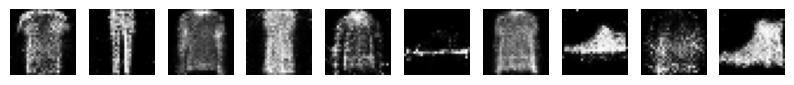

In [53]:
import numpy as np
import matplotlib.pyplot as plt
with torch.no_grad():
    noise = torch.randn(10,100).to(device)
    labels = torch.LongTensor(np.arange(10)).to(device)
    samples = generator(noise,labels).cpu().data
    figs,axs=plt.subplots(1,10,figsize=(10,1))
    for j in range(10):
        axs[j].imshow(samples[j].reshape(28,28),cmap='gray')
        axs[j].axis('off')
    plt.show()